# Load data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score
from mlxtend.frequent_patterns import apriori
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from community import community_louvain
from datasketch import MinHash, MinHashLSH
from sklearn.metrics import davies_bouldin_score
import numpy as np
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt


/Users/malfridurannaeiriksdottir/anaconda3/envs/myMLvenv/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/malfridurannaeiriksdottir/anaconda3/envs/myMLvenv/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/malfridurannaeiriksdottir/anaconda3/envs/myMLvenv/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/malfridurannaeiriksdottir/anaconda3/envs/myMLvenv/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
df = pd.read_csv("../data/fake reviews dataset.csv")
print(df.info())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40432 non-null  object
 1   rating    40432 non-null  int64 
 2   label     40432 non-null  object
 3   text_     40432 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB
None
              category        rating  label  \
count            40432  40432.000000  40432   
unique              10           NaN      2   
top     Kindle_Store_5           NaN     CG   
freq              4730           NaN  20216   
mean               NaN      4.256579    NaN   
std                NaN      1.144354    NaN   
min                NaN      1.000000    NaN   
25%                NaN      4.000000    NaN   
50%                NaN      5.000000    NaN   
75%                NaN      5.000000    NaN   
max                NaN      5.000000    NaN   

                                            

# Feature engineering

In [3]:
df['text_length'] = df['text_'].apply(len)

df['sentiment'] = df['text_'].apply(lambda x: TextBlob(x).sentiment.polarity)



In [4]:
category_mean_ratings = df.groupby('category')['rating'].transform('mean')


In [5]:
df = pd.get_dummies(df, columns=['category'])


In [6]:
df['rating_deviation'] = df['rating'] - category_mean_ratings

scaler = StandardScaler()
df[['text_length', 'sentiment', 'rating_deviation']] = scaler.fit_transform(df[['text_length', 'sentiment', 'rating_deviation']])

# Vectorize and encode
TF IDF

In [7]:
tfidf = TfidfVectorizer(max_features=1000)
text_features = tfidf.fit_transform(df['text_']).toarray()

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])  # 0 for OR, 1 for CG


# Random Forest classifier

In [8]:
X = np.hstack((df[['text_length', 'sentiment', 'rating_deviation']].values, text_features))
y = df['label_encoded']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [11]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      6066
           1       0.87      0.88      0.88      6064

    accuracy                           0.88     12130
   macro avg       0.88      0.88      0.88     12130
weighted avg       0.88      0.88      0.88     12130

[[5296  770]
 [ 738 5326]]


# Clustering

Lower values of the Davies-Bouldin Index indicate better-defined, well-separated clusters.

In [12]:

# Using k-means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_kmeans = kmeans.fit_predict(X)

# Using DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X)

# Evaluate clustering quality
dbi_kmeans = davies_bouldin_score(X, clusters_kmeans)
print(f'Davies-Bouldin Index for k-means: {dbi_kmeans}')

if len(set(clusters_dbscan)) > 1:  # Avoid single-cluster DBSCAN cases
    dbi_dbscan = davies_bouldin_score(X, clusters_dbscan)
    print(f'Davies-Bouldin Index for DBSCAN: {dbi_dbscan}')


Davies-Bouldin Index for k-means: 1.7162248095472137
Davies-Bouldin Index for DBSCAN: 0.957542461893529


In [13]:
# Define the range of parameters
eps_values = np.arange(0.3, 1.0, 0.1)
min_samples_values = range(3, 10)

# Dictionary to store DBI scores for each (eps, min_samples) pair
dbi_scores = {}


In [15]:
eps_values

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [16]:
# Fine-tuning loop
print('Starting fine tuning loop:')
for eps in tqdm.tqdm(eps_values):
    print('eps',eps)
    for min_samples in tqdm.tqdm(min_samples_values):
        print('     -- min sample val',min_samples)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Only calculate DBI if more than one cluster is found
        if len(set(labels)) > 1:
            dbi = davies_bouldin_score(X, labels)
            dbi_scores[(eps, min_samples)] = dbi

# Sort results by DBI score (lower is better)
sorted_dbi_scores = sorted(dbi_scores.items(), key=lambda item: item[1])
best_params = sorted_dbi_scores[0][0]
print(f"Best DBSCAN params (eps, min_samples): {best_params}")


Starting fine tuning loop:


  0%|          | 0/7 [00:00<?, ?it/s]

eps 0.3


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 14%|█▍        | 1/7 [02:15<13:35, 135.87s/it]

eps 0.4


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 29%|██▊       | 2/7 [04:55<12:28, 149.67s/it]

eps 0.5


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 43%|████▎     | 3/7 [07:46<10:37, 159.49s/it]

eps 0.6000000000000001


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 57%|█████▋    | 4/7 [10:58<08:37, 172.53s/it]

eps 0.7000000000000002


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 71%|███████▏  | 5/7 [14:35<06:16, 188.25s/it]

eps 0.8000000000000002


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


 86%|████████▌ | 6/7 [18:13<03:18, 198.47s/it]

eps 0.9000000000000001


min sample val 3


min sample val 4


min sample val 5


min sample val 6


min sample val 7


min sample val 8


min sample val 9


100%|██████████| 7/7 [21:56<00:00, 188.02s/it]

Best DBSCAN params (eps, min_samples): (0.4, 9)


In [18]:
# Run DBSCAN with the best parameters
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
labels = dbscan.fit_predict(X)

  0%|          | 0/4 [00:00<?, ?it/s]

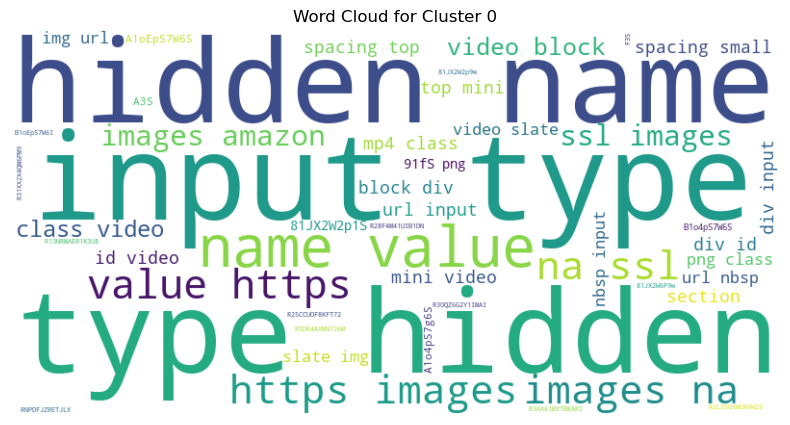

 25%|██▌       | 1/4 [00:00<00:01,  2.43it/s]

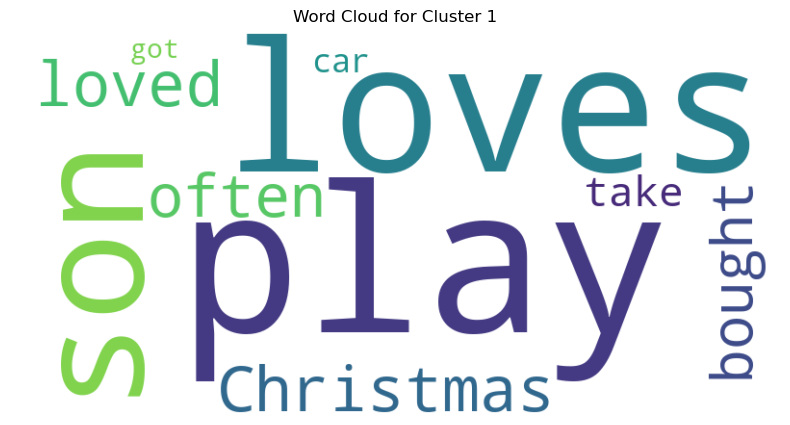

 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

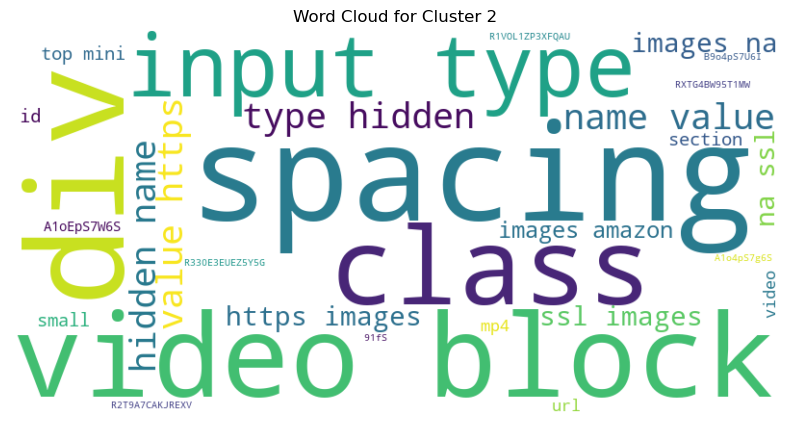

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


In [19]:
# Add labels to the original DataFrame for easy reference
df['cluster'] = labels

# Generate word clouds for each cluster
unique_clusters = set(labels)
for cluster in tqdm.tqdm(unique_clusters):
    if cluster == -1:
        continue  # Skip noise points
    cluster_text = " ".join(df[df['cluster'] == cluster]['text_'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Cluster {cluster}")
    plt.show()


In [24]:
# Count label occurrences within each cluster
label_counts = df.groupby(['cluster', 'label']).size().unstack(fill_value=0)

# Calculate proportion of CG and OR in each cluster
label_proportions = label_counts.div(label_counts.sum(axis=1), axis=0)
print(label_proportions)


label          CG        OR
cluster                    
-1       0.499678  0.500322
 0       1.000000  0.000000
 1       1.000000  0.000000
 2       1.000000  0.000000


# CURE

In [27]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report

# Apply Agglomerative Clustering with two clusters to approximate CURE
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='average')
labels_agg = agglomerative.fit_predict(X)

In [ ]:
# Map clusters to labels based on majority class in each cluster
df['agglomerative_cluster'] = labels_agg
agg_label_mapping = df.groupby('agglomerative_cluster')['label'].agg(lambda x: x.value_counts().idxmax())
df['agg_predicted_label'] = df['agglomerative_cluster'].map(agg_label_mapping)

In [ ]:




# Evaluate clustering with confusion matrix
true_labels = df['label']
predicted_labels = df['agg_predicted_label']
cm = confusion_matrix(true_labels, predicted_labels, labels=['CG', 'OR'])
report = classification_report(true_labels, predicted_labels, target_names=['CG', 'OR'])

print("Confusion Matrix for Agglomerative Clustering:")
print(cm)
print("\nClassification Report for Agglomerative Clustering:")
print(report)


# hierarchical

In [15]:
X[0:10]


array([[-0.74706664,  0.90807151,  0.65962295, ...,  0.        ,
         0.        ,  0.        ],
       [-0.73354614,  1.27163243,  0.65962295, ...,  0.        ,
         0.        ,  0.        ],
       [-0.76869942, -0.05366355,  0.65962295, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.72002565,  0.69853147, -1.0918865 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.73084204,  0.19706813,  0.65962295, ...,  0.        ,
         0.        ,  0.        ],
       [-0.74977073, -0.26857641,  0.65962295, ...,  0.        ,
         0.        ,  0.        ]])

In [14]:
len(X[0:10])

10

In [23]:

# Step 1: Plot a dendrogram to visualize potential clusters
print('plot dendrogram')
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Reviews")
plt.ylabel("Euclidean Distances")
plt.show()

plot dendrogram


In [12]:
# Step 2: Apply Agglomerative Clustering with 2 clusters
print('clustering')
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_agg = agglomerative.fit_predict(X)

clustering


In [19]:
# Step 3: Map clusters to labels based on majority class in each cluster
df['agglomerative_cluster'] = labels_agg
agg_label_mapping = df.groupby('agglomerative_cluster')['label'].agg(lambda x: x.value_counts().idxmax())
df['agg_predicted_label'] = df['agglomerative_cluster'].map(agg_label_mapping)

ValueError: Length of values (100) does not match length of index (40432)

In [11]:






# Step 4: Generate confusion matrix and classification report
true_labels = df['label']
predicted_labels = df['agg_predicted_label']
cm = confusion_matrix(true_labels, predicted_labels, labels=['CG', 'OR'])
report = classification_report(true_labels, predicted_labels, target_names=['CG', 'OR'])

print("Confusion Matrix for Hierarchical Clustering:")
print(cm)
print("\nClassification Report for Hierarchical Clustering:")
print(report)


In [10]:
from sklearn.decomposition import PCA

# Reduce dimensions to a smaller number, e.g., 50 components
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)


In [11]:
# Sample a subset for faster hierarchical clustering
sampled_df = df.sample(n=5000, random_state=42)
X_sampled = X[sampled_df.index]

# Apply clustering on the sample, then use these labels to train a classifier


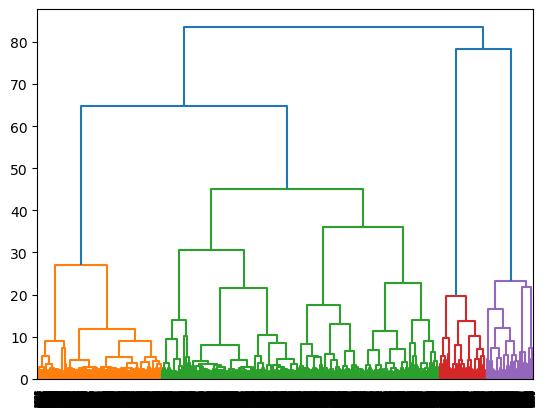

In [12]:
import fastcluster
from scipy.cluster.hierarchy import fcluster, dendrogram

# Perform clustering with FastCluster
Z = fastcluster.linkage_vector(X_sampled, method='ward')
dendrogram(Z)  # This can still be slow but faster than `scipy`
clusters = fcluster(Z, t=2, criterion='maxclust')


In [13]:
from sklearn.cluster import KMeans

# Apply k-means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Map clusters and evaluate


In [14]:
from sklearn.decomposition import PCA

# Reduce dimensions to 50 components for speed
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X)  # Assuming X is your features matrix


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

# Apply k-means with 2 clusters on the reduced data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)


In [16]:
# Add k-means cluster labels to the original DataFrame
df['kmeans_cluster'] = kmeans_labels

# Map clusters to labels based on majority class in each cluster
kmeans_label_mapping = df.groupby('kmeans_cluster')['label'].agg(lambda x: x.value_counts().idxmax())
df['kmeans_predicted_label'] = df['kmeans_cluster'].map(kmeans_label_mapping)


In [17]:
# True and predicted labels for evaluation
true_labels = df['label']
predicted_labels = df['kmeans_predicted_label']

# Confusion Matrix and Classification Report
cm = confusion_matrix(true_labels, predicted_labels, labels=['CG', 'OR'])
report = classification_report(true_labels, predicted_labels, target_names=['CG', 'OR'])

print("Confusion Matrix for k-means with 2 Clusters:")
print(cm)
print("\nClassification Report for k-means with 2 Clusters:")
print(report)


Confusion Matrix for k-means with 2 Clusters:
[[14817  5399]
 [13582  6634]]

Classification Report for k-means with 2 Clusters:
              precision    recall  f1-score   support

          CG       0.52      0.73      0.61     20216
          OR       0.55      0.33      0.41     20216

    accuracy                           0.53     40432
   macro avg       0.54      0.53      0.51     40432
weighted avg       0.54      0.53      0.51     40432

